# Lancement depuis Google colab

In [ ]:
from google.colab import auth

In [ ]:
auth.authenticate_user()

In [ ]:
project_id = 'le-wagon-337814'
!gcloud config set project {project_id}
!gsutil ls

In [ ]:
! pip install --quiet git+https://github.com/christophelanson/icangetyoursmile

# tensorflow.data.Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random

## Train test split dataset

In [21]:
data_size = 5000 #(number of images to train on)
image_size = (64,64)

In [22]:
from sklearn.model_selection import train_test_split

path_to_mask_file = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/Mask/with-mask-default-mask-seed'
path_to_no_mask_file = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/No_mask/seed'

# File_list : list of all files
file_list = [(f'{path_to_mask_file}{str(i).zfill(4)}.png', f'{path_to_no_mask_file}{str(i).zfill(4)}.png') for i in np.arange(data_size)]

train,test= train_test_split(file_list,test_size=0.2,random_state=1,shuffle=True)
train[:2]

[('/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/Mask/with-mask-default-mask-seed1233.png',
  '/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/No_mask/seed1233.png'),
 ('/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/Mask/with-mask-default-mask-seed1056.png',
  '/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/No_mask/seed1056.png')]

## Read image function (X and y)

In [23]:
def X_y_images(filename):
    """ return X (mask) and y (no mask) from a file name"""
    #mask_im = np.asarray(Image.open(filename[0])).tolist()
    #no_mask_im = np.asarray(Image.open(filename[1])).tolist()
    
    mask_image = tf.io.read_file(filename[0])
    mask_image = tf.image.decode_png(mask_image)
    mask_image = tf.image.convert_image_dtype(mask_image, tf.float32)
    
    no_mask_image = tf.io.read_file(filename[1])
    no_mask_image = tf.image.decode_png(no_mask_image)
    no_mask_image = tf.image.convert_image_dtype(no_mask_image, tf.float32)
    
    return mask_image, no_mask_image

## Image augmentation

TO BE DONE

## Create dataset

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [25]:
# Create dataset as a sliced dataset
def create_dataset(file_list, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    # Shuffle data (so that the ordering is different at each epoch)
    ds = ds.shuffle(buffer_size=len(file_list))
    # Map dataset to get images
    ds = ds.map(X_y_images, num_parallel_calls=AUTOTUNE)
    # Map for data augmentation
    #ds = ds.map(image_augmentation_function, num_parallel_calls=5)
    # Batching
    ds = ds.batch(batch_size)
    # Prefetch (use several resources at the same time)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [26]:
create_dataset(train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None))>

# Create model

## Data

In [27]:
train_ds=create_dataset(train)
test_ds=create_dataset(test)

## Model

In [28]:
from icangetyoursmile.models import unet, create_data_augmentation_model, join_unet_augm_models

In [29]:
input_size = (image_size[0], image_size[1],3)
input_size

(64, 64, 3)

In [31]:
model = join_unet_augm_models(unet(starting_power=5, input_size=input_size),
                              create_data_augmentation_model(random_flip="horizontal", random_rotation=0.03))

In [32]:
# callback to save model training on 5 images
from icangetyoursmile.custom_callbacks import CustomCallback
image_log = dict()
save_predict = CustomCallback(test, image_log)

In [33]:
# Data preparation for visualisation of 5 images through training
X_visu = []
path = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/'
for number in range(5):
        rand_img_nb = random.randint(0,9999)
        mask_path = f'{path}Mask/with-mask-default-mask-seed{str(rand_img_nb).zfill(4)}.png'
        mask_im = np.asarray(Image.open(mask_path)).tolist()
        X_visu.append(mask_im)

image_log = dict()

In [36]:
# early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience= 150, restore_best_weights=True)

In [38]:
model_name='full_Unet_pwr5_64_800epochs_dataset5000'
history = model.fit(train_ds,
                    epochs=250, 
                    batch_size = 16,
                    #steps_per_epoch=steps_per_epoch,
                    #validation_steps=validation_steps,
                    validation_data=test_ds,
                    callbacks=[CustomCallback(X_visu, image_log)])


Epoch 1/250
125/125 [==============================] - 161s 1s/step - loss: 0.0233 - val_loss: 0.0121
Epoch 2/250
125/125 [==============================] - 153s 1s/step - loss: 0.0210 - val_loss: 0.0130
Epoch 3/250
125/125 [==============================] - 160s 1s/step - loss: 0.0196 - val_loss: 0.0143
Epoch 4/250
125/125 [==============================] - 140s 1s/step - loss: 0.0182 - val_loss: 0.0131
Epoch 5/250
125/125 [==============================] - 149s 1s/step - loss: 0.0177 - val_loss: 0.0121
Epoch 6/250
125/125 [==============================] - 142s 1s/step - loss: 0.0171 - val_loss: 0.0134
Epoch 7/250
125/125 [==============================] - 142s 1s/step - loss: 0.0168 - val_loss: 0.0109
Epoch 8/250
125/125 [==============================] - 148s 1s/step - loss: 0.0165 - val_loss: 0.0123
Epoch 9/250
125/125 [==============================] - 145s 1s/step - loss: 0.0164 - val_loss: 0.0112
Epoch 10/250
125/125 [==============================] - 154s 1s/step - loss: 0.016

Epoch 42/250
125/125 [==============================] - 136s 1s/step - loss: 0.0085 - val_loss: 0.0042
Epoch 43/250
125/125 [==============================] - 136s 1s/step - loss: 0.0086 - val_loss: 0.0048
Epoch 44/250
125/125 [==============================] - 137s 1s/step - loss: 0.0084 - val_loss: 0.0045
Epoch 45/250
125/125 [==============================] - 136s 1s/step - loss: 0.0082 - val_loss: 0.0039
Epoch 46/250
125/125 [==============================] - 137s 1s/step - loss: 0.0079 - val_loss: 0.0040
Epoch 47/250
125/125 [==============================] - 136s 1s/step - loss: 0.0077 - val_loss: 0.0038
Epoch 48/250
125/125 [==============================] - 136s 1s/step - loss: 0.0076 - val_loss: 0.0041
Epoch 49/250
125/125 [==============================] - 136s 1s/step - loss: 0.0074 - val_loss: 0.0037
Epoch 50/250
125/125 [==============================] - 135s 1s/step - loss: 0.0074 - val_loss: 0.0037
Epoch 51/250
125/125 [==============================] - 135s 1s/step - lo

Epoch 90/250
125/125 [==============================] - 142s 1s/step - loss: 0.0050 - val_loss: 0.0021
Epoch 91/250
125/125 [==============================] - 135s 1s/step - loss: 0.0049 - val_loss: 0.0021
Epoch 92/250
125/125 [==============================] - 135s 1s/step - loss: 0.0049 - val_loss: 0.0020
Epoch 93/250
125/125 [==============================] - 135s 1s/step - loss: 0.0049 - val_loss: 0.0020
Epoch 94/250
125/125 [==============================] - 134s 1s/step - loss: 0.0049 - val_loss: 0.0021
Epoch 95/250
125/125 [==============================] - 135s 1s/step - loss: 0.0048 - val_loss: 0.0020
Epoch 96/250
125/125 [==============================] - 134s 1s/step - loss: 0.0048 - val_loss: 0.0020
Epoch 97/250
125/125 [==============================] - 135s 1s/step - loss: 0.0048 - val_loss: 0.0020
Epoch 98/250
125/125 [==============================] - 135s 1s/step - loss: 0.0047 - val_loss: 0.0020
Epoch 99/250
125/125 [==============================] - 135s 1s/step - lo

125/125 [==============================] - 135s 1s/step - loss: 0.0037 - val_loss: 0.0014
Epoch 153/250
125/125 [==============================] - 135s 1s/step - loss: 0.0037 - val_loss: 0.0014
Epoch 154/250
125/125 [==============================] - 136s 1s/step - loss: 0.0037 - val_loss: 0.0014
Epoch 155/250
125/125 [==============================] - 135s 1s/step - loss: 0.0037 - val_loss: 0.0014
Epoch 156/250
125/125 [==============================] - 134s 1s/step - loss: 0.0036 - val_loss: 0.0014
Epoch 157/250
125/125 [==============================] - 135s 1s/step - loss: 0.0037 - val_loss: 0.0014
Epoch 158/250
125/125 [==============================] - 134s 1s/step - loss: 0.0036 - val_loss: 0.0014
Epoch 159/250
125/125 [==============================] - 135s 1s/step - loss: 0.0036 - val_loss: 0.0014
Epoch 160/250
125/125 [==============================] - 135s 1s/step - loss: 0.0036 - val_loss: 0.0014
Epoch 161/250
125/125 [==============================] - 134s 1s/step - loss: 

125/125 [==============================] - 136s 1s/step - loss: 0.0031 - val_loss: 0.0011
Epoch 221/250
125/125 [==============================] - 136s 1s/step - loss: 0.0031 - val_loss: 0.0011
Epoch 222/250
125/125 [==============================] - 136s 1s/step - loss: 0.0030 - val_loss: 0.0011
Epoch 223/250
125/125 [==============================] - 136s 1s/step - loss: 0.0030 - val_loss: 0.0012
Epoch 224/250
125/125 [==============================] - 137s 1s/step - loss: 0.0039 - val_loss: 0.0014
Epoch 225/250
125/125 [==============================] - 137s 1s/step - loss: 0.0032 - val_loss: 0.0011
Epoch 226/250
125/125 [==============================] - 136s 1s/step - loss: 0.0031 - val_loss: 0.0011
Epoch 227/250
125/125 [==============================] - 135s 1s/step - loss: 0.0030 - val_loss: 0.0011
Epoch 228/250
125/125 [==============================] - 136s 1s/step - loss: 0.0030 - val_loss: 0.0011
Epoch 229/250
125/125 [==============================] - 135s 1s/step - loss: 

In [39]:
model_name='full_Unet_pwr5_64_250epochs_dataset5000'
from icangetyoursmile.utils import save_model
save_model(model, model_name)

INFO:tensorflow:Assets written to: ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/assets


In [88]:
import pickle
with open(f'./image_logs/{model_name}_img_log.pickle', 'wb') as handle:
    pickle.dump(image_log, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
y_pred = model.predict(X_visu).astype(np.uint8)

In [46]:
def plot_results(X_test, y_pred):
    plt.figure(figsize=(20,10))
    nb_graphs = len(X_test)
    for graph_nb in range(nb_graphs):
        plt.subplot(2,nb_graphs, graph_nb+1)
        plt.imshow(X_test[graph_nb])
        plt.subplot(2,nb_graphs, graph_nb +1 +nb_graphs)
        plt.imshow(y_pred[graph_nb])

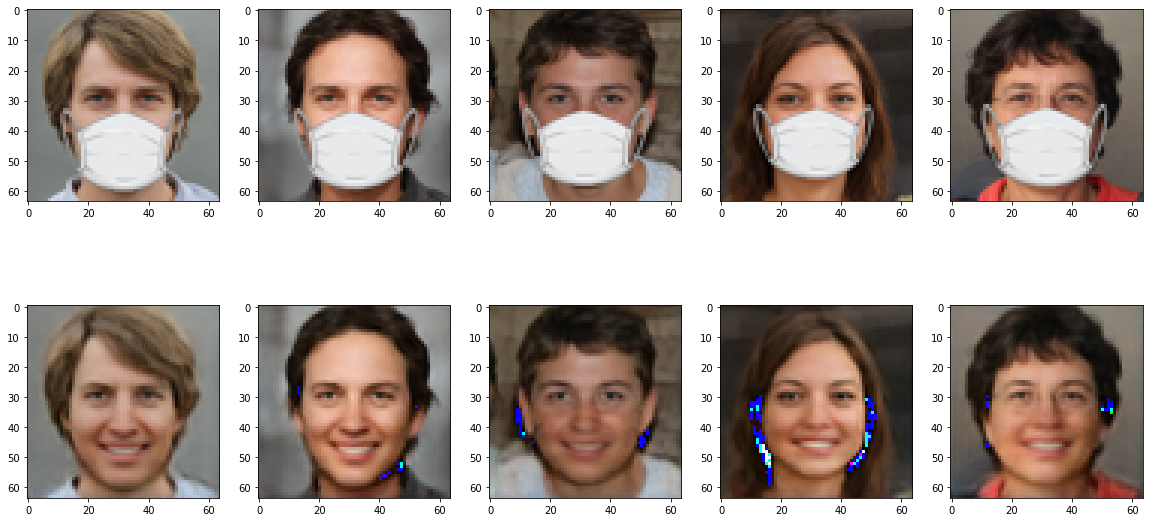

In [48]:
plot_results(X_visu, y_pred);

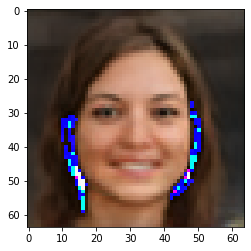

In [85]:
plt.imshow(image_log[100][3])

In [89]:
from icangetyoursmile.trainer import upload_model_to_gcp
upload_model_to_gcp(model_name, run_locally=True)

uploading image_log to gcp
uploading model to gcp
uploading : ./saved_models/U-net-christophe/keras_metadata.pb
uploading : ./saved_models/U-net-christophe/saved_model.pb
uploading : ./saved_models/U-net-christophe/variables/variables.index
uploading : ./saved_models/U-net-christophe/variables/variables.data-00000-of-00001
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/keras_metadata.pb
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/saved_model.pb
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/variables/variables.index
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/variables/variables.data-00000-of-00001
upload finished

all done
